# Higgs Challenge Example

(based on [HiggsChallenge.ipynb from LMU block course](https://github.com/nikoladze/LMU_DA_ML/blob/master/HiggsChallenge.ipynb))

We will use the dataset from the **[Higgs Boson ML Challenge](https://www.kaggle.com/c/Higgs-boson)** since it shows a few peculiarities often encountered in particle physics applications.

* The data is available from **[CERN Open Data](http://opendata.cern.ch/record/328)**.
  * more information about the data is available from the links, and in particular in the accompanying **[documentation](http://opendata.cern.ch/record/329/files/atlas-higgs-challenge-2014.pdf)**.
  * much of the description below is taken from this documentation
* The general idea is that we want to extract $H\to\tau^+\tau^-$ signal from background. 
  * first channel where coupling of Higgs boson to fermions can be proven (before only coupling to bosons, $\gamma$, $W$, $Z$)
  * by now seen many other decays of Higgs, too, most recently even evidence for $H\to\mu^+\mu^-$
* In particular, selection here requires one of the taus to decay into an electron or muon and two neutrinos, and the other into hadrons and a neutrino. 
* The challenge is based on Monte Carlo collision events processed through the **[ATLAS detector](http://atlas.cern/)** simulation and reconstruction.

## LHC and ATLAS
* LHC collides bunches of protons every 25 nanoseconds inside ATLAS detector
* In the hard-scattering process, two colliding protons interact and part of the kinetic energy of the protons is converted into new particles.
* Most resulting particles are unstable and short-lived → decay quickly into a cascade of lighter particles.
* ATLAS detector measures the properties of the decay products: type, energy and momentum (3-D direction)
* The decay products are identified and reconstructed from the low-level analogue and digital signals they trigger in the detector hardware.
* Part of the energy will be converted into and carried away by neutrinos (e.g. from the decay of tau leptons, $\tau^- \to e^- \nu_\tau \bar\nu_e$) that cannot be measured, leading to an incomplete event reconstruction and an imbalance in the total transverse momentum.

Some event displays that visualize collision events found in real data that show a signature matching a $H\to\tau\tau$ decay can be found on the [public ATLAS page][1]. [This event][2], for example, shows $H\to\tau\tau$ with one tau lepton further decaying leptonically and the other hadronically.

[1]: https://twiki.cern.ch/twiki/bin/view/AtlasPublic/EventDisplaysFromHiggsSearches#H_AN1
[2]: https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/CONFNOTES/ATLAS-CONF-2012-160/figaux_07.png

In [1]:
    import os
    import urllib

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

In [2]:
filename = "atlas-higgs-challenge-2014-v2.csv.gz"
url = "http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz"

In [3]:
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
df = pd.read_csv(filename)

In [4]:
df

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,...,1.190,-0.766,41.791,0.787,-1.090,154.056,0.005721,s,u,0.259892
818234,918234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,...,1.293,-0.868,70.158,-2.018,2.893,178.856,0.000461,s,u,0.020956
818235,918235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.189365,b,u,53.284258
818236,918236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,...,1.460,2.637,-999.000,-999.000,-999.000,30.863,0.512740,b,u,22.971060


## The Dataset
The data contains > 800 k simulated collision events, that were used in the reference [ATLAS analysis][1]:
* 250 k for training
* 100 k for testing (public leaderboard)
* 450 k for testing (private leaderboard)
* a small withheld dataset

Here, we use the full dataset:

[1]: http://cds.cern.ch/record/1632191

In [5]:
df.groupby("KaggleSet").count()["EventId"]

KaggleSet
b    100000
t    250000
u     18238
v    450000
Name: EventId, dtype: int64

The dataset mixes background (b) and signal (s) events:

In [6]:
df.groupby("Label").size()

Label
b    538678
s    279560
dtype: int64

If the actual $s:b$ ratio were so large ($\sim1/3$), we would have found the Higgs much earlier. 
To obtain the actual number of signal and background events we expect in the 2012 ATLAS dataset, we need to take into account the provided weights:

In [7]:
df.groupby("Label").Weight.sum()

Label
b    410999.847322
s       691.988608
Name: Weight, dtype: float64

That is, without any additional selection we expect a signal-background ratio of only 1.7 permille.

Each simulated event has a weight
* proportional to the conditional density divided by the instrumental density used by the simulator (an importance-sampling flavor),
* and normalized for integrated luminosity (the size of the dataset; factors in cross section, beam intensity and run time of the collider)

The weights are an artifact of the way the simulation works and not part of the input to the classifier.

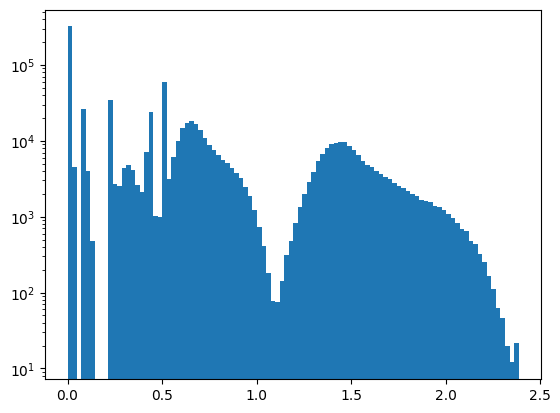

In [8]:
# different weights correspond roughly to different background processes (due to the different cross sections)
ax = plt.hist(df["Weight"], bins = 100)
plt.yscale('log')

Only three different background processes were retained in this dataset ($Z\to\tau\tau$, top-quark-pair production, $W\to\ell\nu$).

## Exploring the data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818238 entries, 0 to 818237
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      818238 non-null  int64  
 1   DER_mass_MMC                 818238 non-null  float64
 2   DER_mass_transverse_met_lep  818238 non-null  float64
 3   DER_mass_vis                 818238 non-null  float64
 4   DER_pt_h                     818238 non-null  float64
 5   DER_deltaeta_jet_jet         818238 non-null  float64
 6   DER_mass_jet_jet             818238 non-null  float64
 7   DER_prodeta_jet_jet          818238 non-null  float64
 8   DER_deltar_tau_lep           818238 non-null  float64
 9   DER_pt_tot                   818238 non-null  float64
 10  DER_sum_pt                   818238 non-null  float64
 11  DER_pt_ratio_lep_tau         818238 non-null  float64
 12  DER_met_phi_centrality       818238 non-null  float64
 13 

In [10]:
df.head().T

,0,1,2,3,4
EventId,100000,100001,100002,100003,100004
DER_mass_MMC,138.47,160.937,-999.0,143.905,175.864
DER_mass_transverse_met_lep,51.655,68.768,162.172,81.417,16.915
DER_mass_vis,97.827,103.235,125.953,80.943,134.805
DER_pt_h,27.98,48.146,35.635,0.414,16.405
DER_deltaeta_jet_jet,0.91,-999.0,-999.0,-999.0,-999.0
DER_mass_jet_jet,124.711,-999.0,-999.0,-999.0,-999.0
DER_prodeta_jet_jet,2.666,-999.0,-999.0,-999.0,-999.0
DER_deltar_tau_lep,3.064,3.473,3.148,3.31,3.891
DER_pt_tot,41.928,2.078,9.336,0.414,16.405


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
EventId,818238.0,509118.500000,236205.109118,100000.000000,304559.250000,509118.500000,713677.750000,918237.000000
DER_mass_MMC,818238.0,-48.819019,406.118397,-999.000000,78.166000,105.061000,130.730000,1949.261000
DER_mass_transverse_met_lep,818238.0,49.252714,35.378609,0.000000,19.304000,46.484000,73.620000,968.669000
DER_mass_vis,818238.0,81.140561,40.582708,6.329000,59.414000,73.744000,92.188000,1349.351000
DER_pt_h,818238.0,57.849524,63.411938,0.000000,14.164250,38.470000,79.226750,2834.999000
DER_deltaeta_jet_jet,818238.0,-707.740880,454.793899,-999.000000,-999.000000,-999.000000,0.499000,8.724000
DER_mass_jet_jet,818238.0,-600.191191,658.724040,-999.000000,-999.000000,-999.000000,84.031750,4974.979000
DER_prodeta_jet_jet,818238.0,-708.681306,453.328599,-999.000000,-999.000000,-999.000000,-4.548000,17.650000
DER_deltar_tau_lep,818238.0,2.373871,0.780875,0.208000,1.814000,2.492000,2.962000,5.751000
DER_pt_tot,818238.0,18.969617,21.918491,0.000000,2.839000,12.383000,27.634000,2834.999000


### Brief overview of variables, there is more information in the documentation. 
* 30 features
  * The variables that start with **DER** are derived quantities, determined by the physicists performing the analysis as variables that discriminate signal from background. 
  * On the other hand, those that start with **PRI** are considered to be primary variables, from which the derived variables are calculated. 
    * They themselves generally do not provide much discrimination.
    * One of the ideas suggested by deep networks is that they can determine the necessary features from the primary variables, potentially even finding variables that the physicists did not consider. 
* *EventId* identifies the event but is not a "feature." 
* The *Weight* is the event weight.
  * used to obtain the proper normalization of the different signal and background samples
  * sum of weights of all signal events should produce the signal yield expected to be observed in 2012 LHC data taking
  * sum of weights of all background events should produce the background yield
* *Label* indicates if it is a signal or background event. 
* Ignore the *Kaggle* variables --- they are only used if you want to reproduce exactly what was used in the Challenge. 

### Investigate/visualize some parameters

In [12]:
feat_columns = [col for col in df.columns if col[:3] in ["DER", "PRI"]]
len(feat_columns)

30

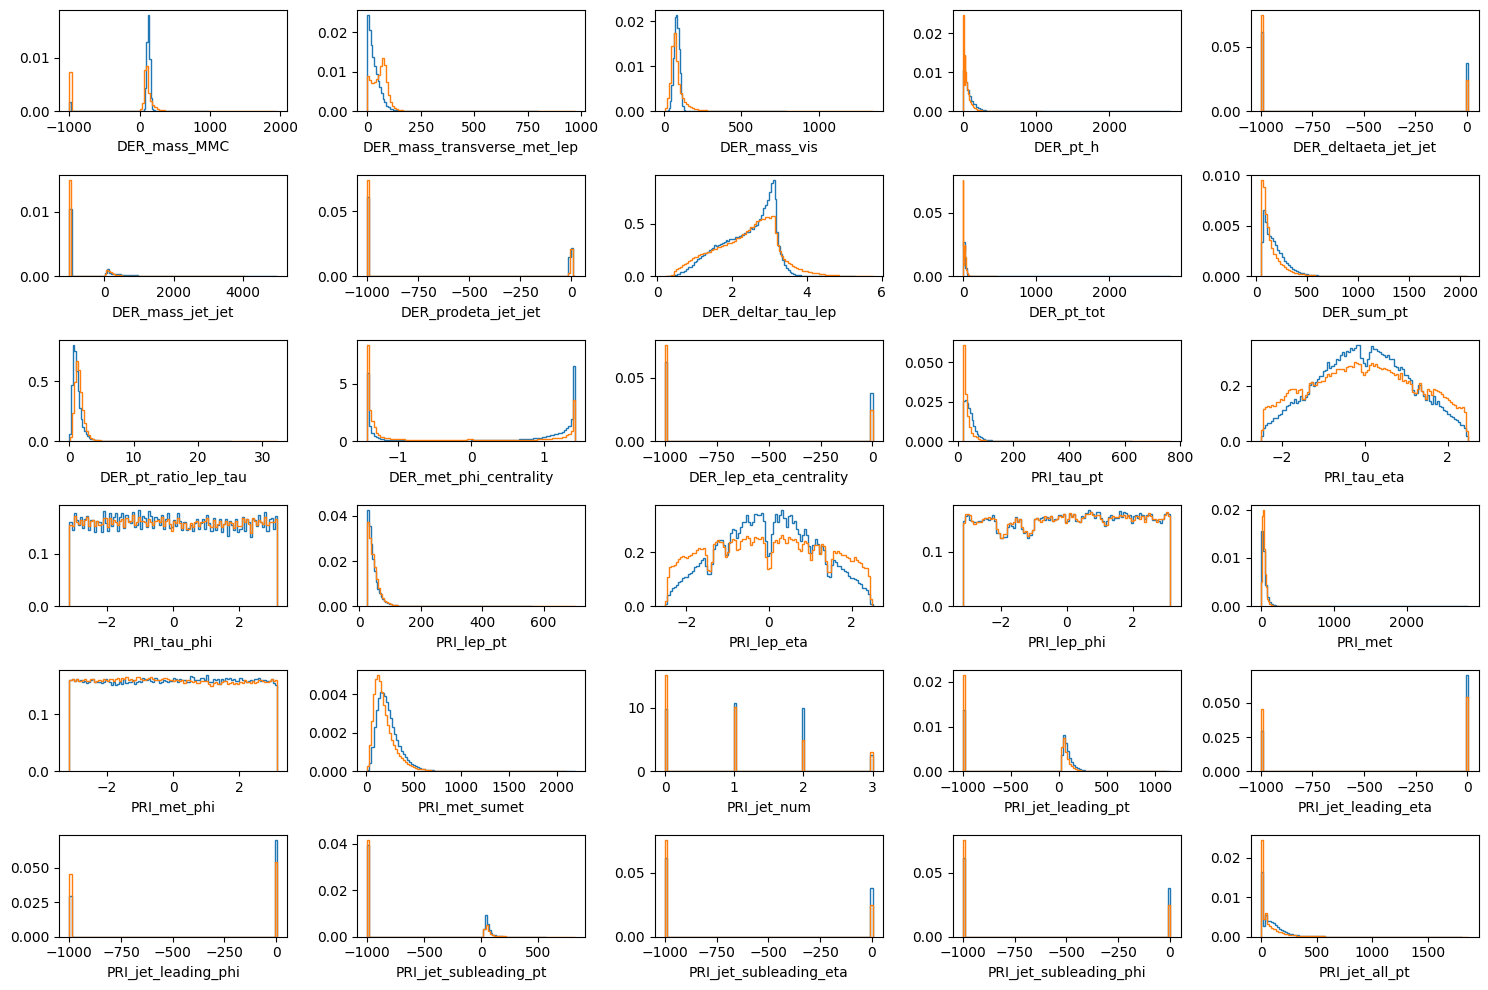

In [13]:
fig, axs = plt.subplots(ncols=5, nrows=6, figsize=(15, 10))
for ax, col in zip(axs.ravel(), feat_columns):
    kwargs = dict(bins=100, histtype="step", density=True)
    ax.hist(df[col][df.Label == "s"], **kwargs)
    ax.hist(df[col][df.Label == "b"], **kwargs)
    ax.set_xlabel(col)
fig.tight_layout()

Not all variables are defined in each event, that's where the `-999` values are used. This happens e.g. for the leading and subleading jet and quantities derived from jets in events where there is no jet or only one jet. So it makes sense to look at the distributions of values that are not `-999`:

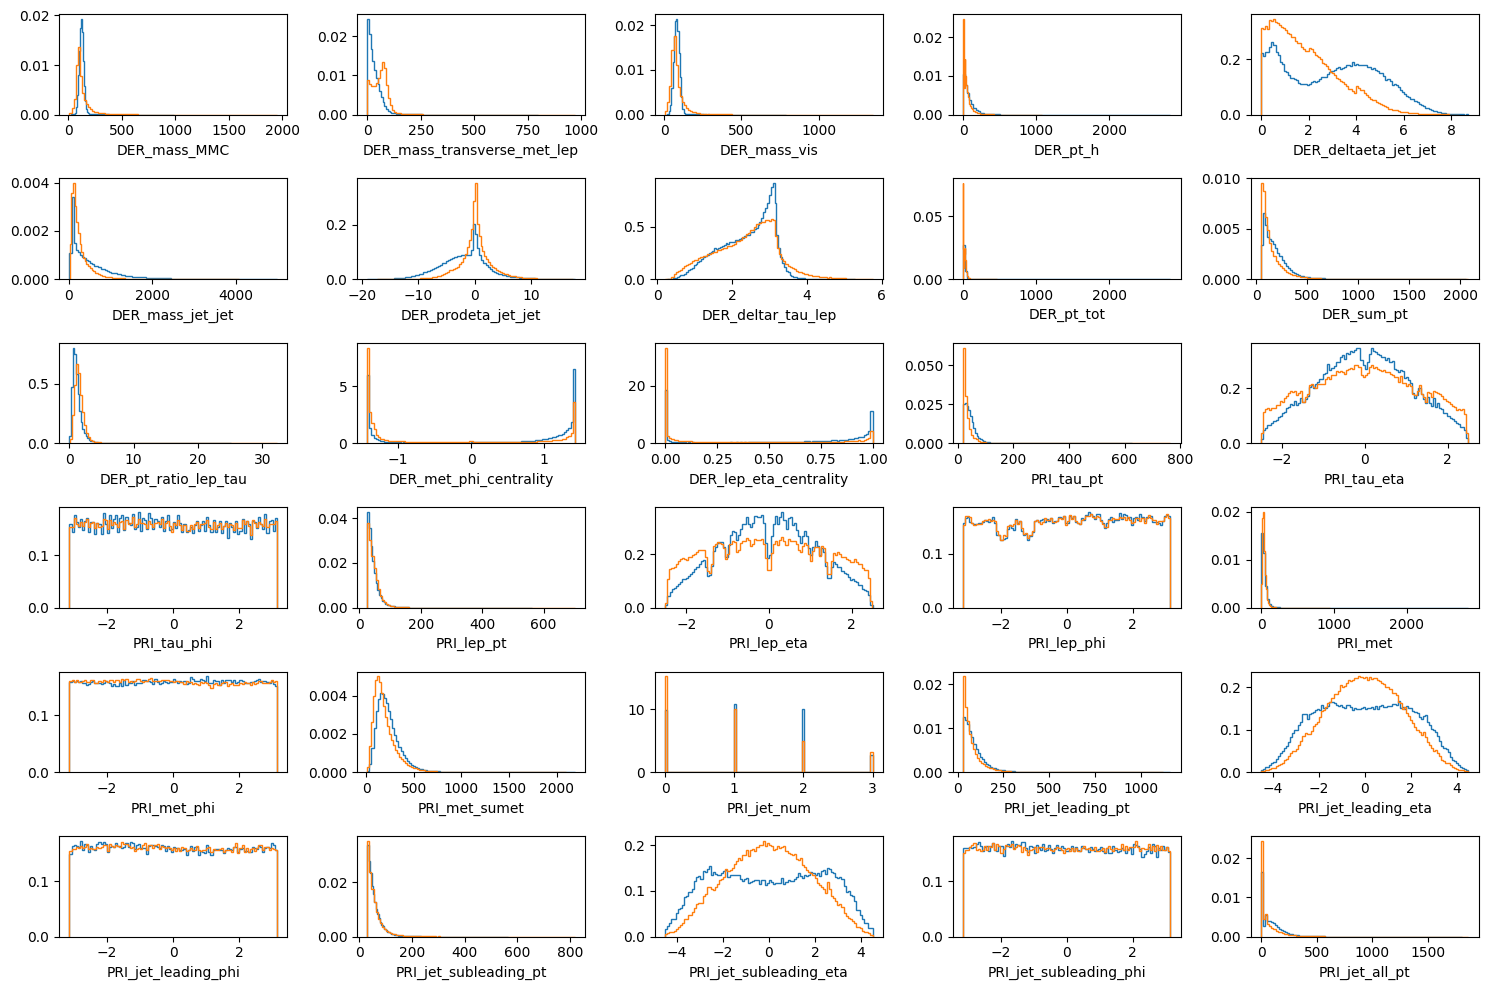

In [14]:
def plot(df):
    fig, axs = plt.subplots(ncols=5, nrows=6, figsize=(15, 10))
    for ax, col in zip(axs.ravel(), feat_columns):
        kwargs = dict(bins=100, histtype="step", density=True)
        x = df[col].to_numpy()
        mask = x != -999
        x = x[mask]
        label = df.Label[mask].to_numpy()
        ax.hist(x[label == "s"], **kwargs)
        ax.hist(x[label == "b"], **kwargs)
        ax.set_xlabel(col)
    fig.tight_layout()

plot(df)

Sometimes it can be instructive to look at 2D plots. The `seaborn` library provides a few helpers for this:

In [15]:
import seaborn as sns

In [16]:
# take sub-set of vars for plotting
varplot = ['DER_mass_MMC', 
           'DER_mass_jet_jet',
           'DER_deltar_tau_lep',
           'DER_pt_tot',
           'PRI_jet_subleading_pt']

Here we only plot events where no variable is -999. Also we only take a random subsample of 10000 events to have reasonable scatterplots:

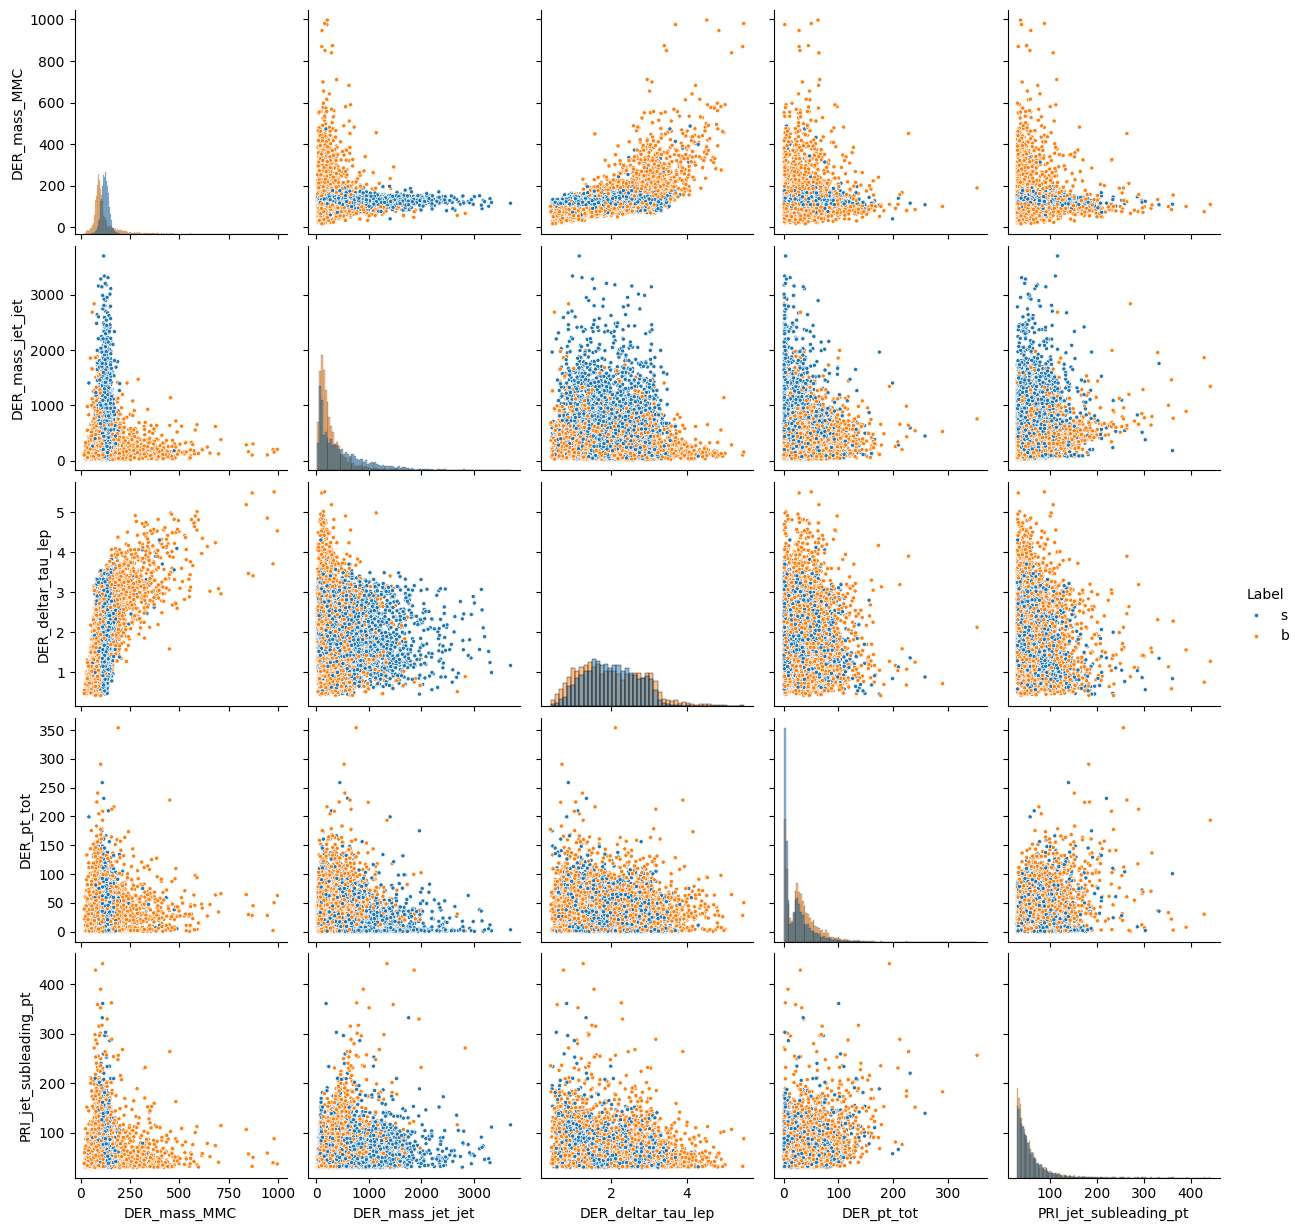

In [17]:
sns.pairplot(
    df[~(df == -999).T.any()].sample(10000),
    diag_kind="hist",
    vars=varplot,
    hue="Label",
    markers="."
)

## Machine learning

Here we have a supervised ML problem where we want to fit a model that predicts from inputs `X` some labels `y`:

In [18]:
X = df.loc[:, feat_columns]
y = df['Label']
weight = df['Weight']

Also here we will use splitting into training and testing.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    weight_train,
    weight_test,
) = train_test_split(
    X.to_numpy(),
    (y == "s").to_numpy(),
    weight.to_numpy(),
    test_size=0.33,
    random_state=42
)

## First ML trials w/ simple models
1st attempt with simple models: GaussianNB and Logistic Regression

### GaussianNB

In [21]:
# GaussianNB (Gaussian Naive Bayes, assumes each class is drawn from an axis-aligned Gaussian distribution)
from sklearn.naive_bayes import GaussianNB

model_gnb= GaussianNB()
model_gnb.fit(X_train, y_train)

GaussianNB()

In [22]:
model_gnb.score(X_test, y_test)

0.6783633744292068

###  Logistic Regression
As next attempt, let's look at [logistic regression][1]. This is a very simple, linear model. In the exercises you can look at optimizing it a bit more.
* logistic function: $f(x) = \frac{1}{1+\exp(-x)}$, $f(x): [-\infty,\infty] \to [0,1]$
* model: $y = f(\vec{x} \cdot \vec{\beta} + \epsilon)$

[1]: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [24]:
model_lr = LogisticRegression(max_iter=1000, solver="lbfgs")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model_lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

<div class="alert alert-block alert-success">
    <h3>Exercise 3</h3>
    Likely the model showed convergence issues. Can you fix this?
</div>

In [25]:
model_lr.score(X_train_scaled, y_train)

0.750658039943891

In [26]:
model_lr.score(X_test_scaled, y_test)

0.7503212736881478

## More sophisticated model: [GradientBoostingClassifier][1]
* ensemble method that combines multiple decision trees
* "forward stage-wise fashion: each tree tries to correct the mistakes of the previous one (steered by the `learning_rate`)
* individual trees can be simple (shallow), idea is to combine many "weak learners" 
  * each tree can only provide good predictions on part of the data, but combined they can yield a powerful model
  
[1]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

To speed up the training we will use subsampling ("stochastic gradient boosting") here - train each tree on a random subset of the data:

In [28]:
model_gbc = GradientBoostingClassifier(subsample=0.01, verbose=1)

In [29]:
model_gbc.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2189           0.0579           16.17s
         2           1.1691           0.0534           13.87s
         3           1.1345           0.0420           12.96s
         4           1.1000           0.0373           12.79s
         5           1.0488           0.0315           12.34s
         6           1.0281           0.0289           12.00s
         7           1.0058           0.0254           11.94s
         8           0.9901           0.0216           11.72s
         9           0.9755           0.0183           11.63s
        10           0.9509           0.0178           11.55s
        20           0.8542           0.0060           10.47s
        30           0.8067           0.0025            9.40s
        40           0.7763           0.0013            8.39s
        50           0.7693           0.0009            8.59s
        60           0.7611           0.0012            7.43s
       

GradientBoostingClassifier(subsample=0.01, verbose=1)

In [30]:
model_gbc.score(X_test, y_test)

0.8305193338246568

Alternative for larger datasets: [`HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

This also trains sufficiently fast on a dataset this size, even without subsampling:

In [31]:
from sklearn.ensemble import HistGradientBoostingClassifier

model_gbc = HistGradientBoostingClassifier()
model_gbc.fit(X_train, y_train)
model_gbc.score(X_test, y_test)

0.8410297053170332

# How to evaluate and compare performance?

While the Accuracy can be useful to compare different methods on the same dataset it has often a bit limited information in typical particle-physics classification applications because we often want to distinguish rare signals from large background. Most classifiers provide a continuous output score where we can choose a tradeoff between **true positives** (our retained signal)  and **false positives** (the background that's still left over).

This tradeoff is characterized by the so called **ROC curve** ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))

For example, our GradientBoostingClassifier gives predicted probabilities for both classes (first column background, second column signal):

In [32]:
model_gbc.predict_proba(X_test)

array([[0.15365787, 0.84634213],
       [0.95595852, 0.04404148],
       [0.99025874, 0.00974126],
       ...,
       [0.77620002, 0.22379998],
       [0.93881795, 0.06118205],
       [0.9851431 , 0.0148569 ]])

They are typically normalized such that $p_\mathrm{signal} = 1-p_\mathrm{background}$.

In [33]:
p_test = model_gbc.predict_proba(X_test)[:, 1] # predicted probability for signal
p_test

array([0.84634213, 0.04404148, 0.00974126, ..., 0.22379998, 0.06118205,
       0.0148569 ])

To visually get an idea of the separation power we can plot the distribution of predicted probabilities for both classes separately:

In [34]:
def plot_proba(p, y):
    kwargs = dict(bins=100, range=(0, 1), histtype="step")
    plt.hist(p[y==0], label="background", **kwargs)
    plt.hist(p[y==1], label="signal", **kwargs)
    plt.legend()

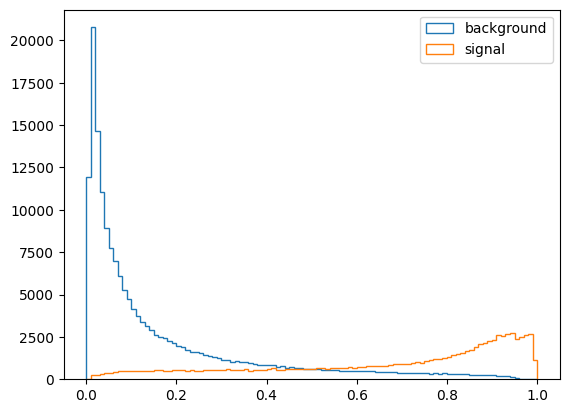

In [35]:
plot_proba(p_test, y_test)

... but one should be a bit careful interpreting these by eye, since they can be a bit misleading.

Especially for comparing different classifiers, the ROC curve is a better option:

In [36]:
from sklearn.metrics import roc_curve

In [37]:
fpr, tpr, thr = roc_curve(y_test, p_test)

Text(0, 0.5, 'true positive rate (Signal efficiency)')

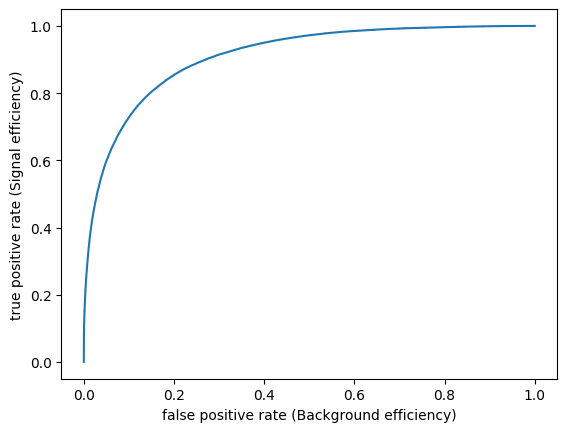

In [38]:
plt.plot(fpr, tpr)
plt.xlabel("false positive rate (Background efficiency)")
plt.ylabel("true positive rate (Signal efficiency)")

We get this curve by looking at every possible cutoff value on the predicted probability:

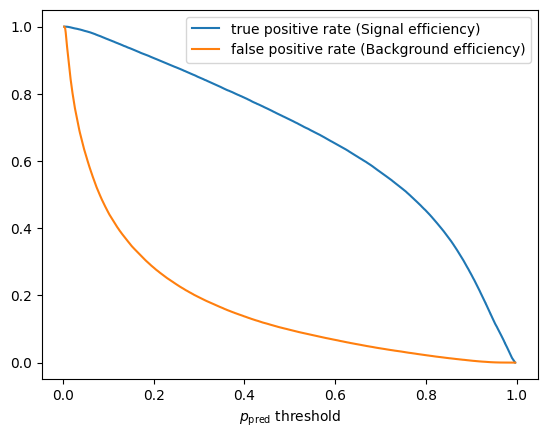

In [39]:
plt.plot(thr, tpr, label="true positive rate (Signal efficiency)")
plt.plot(thr, fpr, label="false positive rate (Background efficiency)")
plt.xlabel(r"$p_\mathrm{pred}$ threshold")
plt.legend()

When high background rejection is important (as often in particle physics) it's also common to plot the true positive rate against the inverse of the false positive rate in logarithmic scale:

C:\Users\maxge\AppData\Local\Temp\ipykernel_5868\2417283460.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr)


Text(0, 0.5, 'Background rejection')

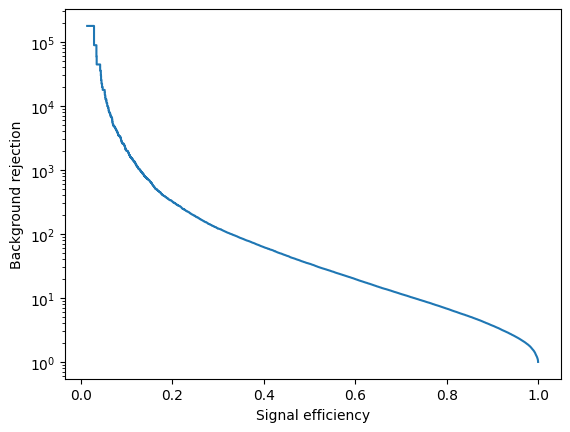

In [40]:
plt.plot(tpr, 1 / fpr)
plt.yscale("log")
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

<div class="alert alert-block alert-success">
    <h3>Exercise 4:</h3> Compare the ROC curve for the Logistic Regression, Gaussian Naive-Bayes and the Gradient Boosting Classifier
</div>

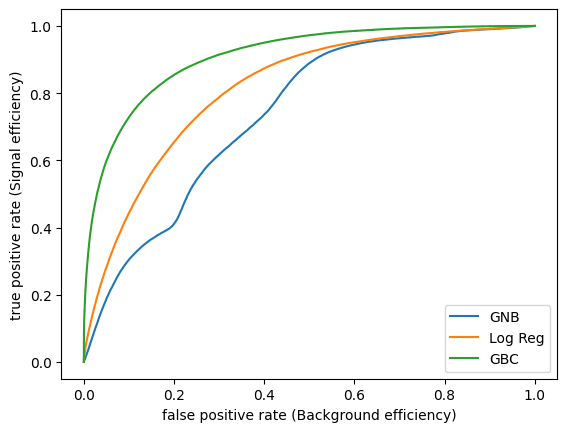

In [41]:
p_test_gauss = model_gnb.predict_proba(X_test)[:, 1]
p_test_lr = model_lr.predict_proba(X_test_scaled)[:,1]
p_test_gbc = model_gbc.predict_proba(X_test)[:,1]

gauss = roc_curve(y_test, p_test_gauss)
lr = roc_curve(y_test, p_test_lr)
gbc = roc_curve(y_test, p_test_gbc)

plt.plot(gauss[0], gauss[1], label="GNB")
plt.plot(lr[0], lr[1], label = "Log Reg")
plt.plot(gbc[0], gbc[1], label="GBC")
plt.xlabel("false positive rate (Background efficiency)")
plt.ylabel("true positive rate (Signal efficiency)")
plt.legend()

## Figure-of-Merit: AMS
Let's get back to the original problem using the GradientBoostingClassifier. The Kaggle competition used the approximate median significance ([AMS][1]), as defined below, to determine how good a solution was. 
The goal is to maximize signal and minimize background, and the AMS is an approximate formula to quantify the expected signal significance.

The formula is based on the result from [arXiv:1007.1727](https://arxiv.org/pdf/1007.1727) which approximates the **discovery significance** (corresponding to the p-value for rejecting the background-only hypothesis) using Wilk's theorem in a counting experiment:

$Z_{0, A} = \sqrt{q_{0, A}} = \sqrt{2((s+b)\ln(1+s/b)-s)}$

For large $b$ this converges to the intuitive rule-of-thumb formula $\frac{s}{\sqrt{b}}$.

[1]: https://github.com/nikoladze/LMU_DA_ML/blob/master/AMS.ipynb

In [42]:
def ams(s, b):
    """
    Approximate median significance, as defined in Higgs Kaggle challenge

    The number 10, added to the background yield, is a regularization term to decrease the variance of the AMS.
    """
    return np.sqrt(2 * ((s + b + 10) * np.log(1 + s / (b + 10)) - s))

To calculate this we need the **absolute normalization** of signal and background. So we need to **sum of weights** for both:

In [43]:
sumw = df.groupby("Label").Weight.sum()
sumw

Label
b    410999.847322
s       691.988608
Name: Weight, dtype: float64

In [44]:
nsig_tot = sumw["s"]
nbkg_tot = sumw["b"]

Using this we can get the AMS value after applying a threshold cut, e.g. for taking all events with predicted probability > 50%:

In [45]:
mask = p_test > 0.5
nsig = weight_test[y_test == 1].sum()
nsig_sel = weight_test[mask][y_test[mask] == 1].sum()
tpr = nsig_sel / nsig
nbkg = weight_test[y_test == 0].sum()
nbkg_sel = weight_test[mask][y_test[mask] == 0].sum()
fpr = nbkg_sel / nbkg

In [46]:
tpr*nsig_tot

473.5184967708008

In [47]:
ams(s=tpr*nsig_tot, b=fpr*nbkg_tot)

2.8854310573484443

<div class="alert alert-block alert-success">
    <h3>Exercise 5:</h3> Plot the AMS against every possible threshold and find the maximum. <b>Hint:</b> Use <code>roc_curve</code> with <code>sample_weight=weight_test</code>
</div>

In [48]:
fpr_weigh, tpr_weigh, thr_weigh = roc_curve(y_test, p_test, sample_weight=weight_test)

Maximum AMS of 3.553 at a threshold of 0.827.


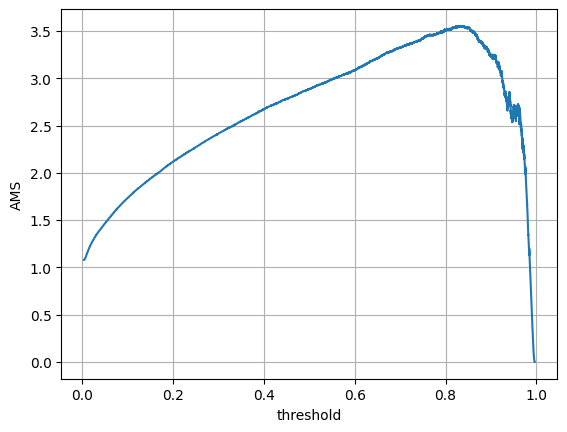

In [50]:
amsses = [ams(tpr*nsig_tot, fpr*nbkg_tot) for tpr, fpr in zip(tpr_weigh, fpr_weigh)]
max_ams = max(amsses)
max_thr = thr_weigh[amsses.index(max_ams)]
print(f"Maximum AMS of {max_ams:.3f} at a threshold of {max_thr:.3f}.")
plt.plot(thr_weigh, amsses)
plt.xlabel("threshold")
plt.ylabel("AMS")
plt.grid()

C:\Users\maxge\AppData\Local\Temp\ipykernel_5868\1739771370.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(thr_weigh, tpr_weigh*nsig_tot / np.sqrt(fpr_weigh*nbkg_tot))
C:\Users\maxge\AppData\Local\Temp\ipykernel_5868\1739771370.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(thr_weigh, tpr_weigh*nsig_tot / np.sqrt(fpr_weigh*nbkg_tot))


Text(0, 0.5, 'ams')

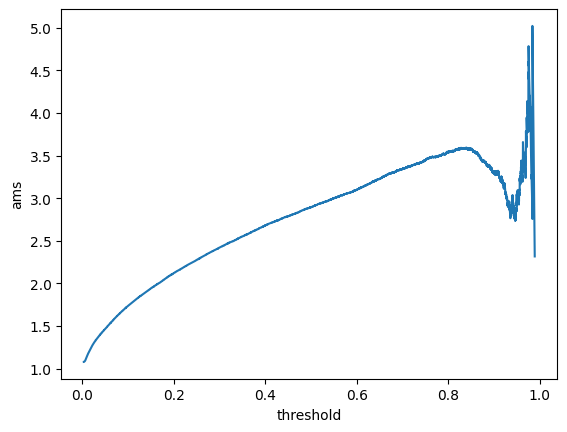

In [58]:
# using approximate formula s/sqrt(b)
plt.plot(thr_weigh, tpr_weigh*nsig_tot / np.sqrt(fpr_weigh*nbkg_tot))
plt.xlabel("threshold")
plt.ylabel("ams")
#plt.xscale("log")

How well did we do? Compare to results of Kaggle challenge:

![](figures/tr150908_davidRousseau_TMVAFuture_HiggsML.001.png)

Note: The *private* data set/Leaderboard on Kaggle is a test data where the scores are only revealed to the participants at the end of the challenge.

### Applying sample weights during training

Knowing that we need to weight the samples in the end we can take this into account in the training for classifiers that support this. This works well for probabilistic classifiers with a loss function, e.g. GradientBoosting or Neural Networks. However, just applying the weights may lead to problems since

* They are not around 1 (shifting the total scale of the loss)
* They are much smaller for the signal (due to the lower cross section) than for the background

To deal with this we scale the weights such that our signal and background classes have the same sum of weights and finally such that the mean weight is 1:

In [51]:
class_weight = np.array([
    len(y_train) / weight_train[y_train==0].sum(),
    len(y_train) / weight_train[y_train==1].sum(),
])
class_weight

array([   1.99091865, 1182.31507086])

In [65]:
weight_for_fit = weight_train * class_weight[y_train.astype(int)]
weight_for_fit /= weight_for_fit.mean()

In [66]:
# check results:
print(weight_for_fit[y_train==0].sum(), weight_for_fit[y_train==1].sum())
weight_for_fit.mean()

274109.5 274109.5


1.0000000000000007

<div class="alert alert-block alert-success">
    <h3>Exercise 6:</h3> The <code>HistGradientBoostingClassifier</code> support weights during training via the <code>sample_weight</code> argument in the <code>fit</code> method. Can you improve by applying the weight?
</div>

In [71]:
model_gbc_weighted = HistGradientBoostingClassifier()#class_weight={0.0:class_weight[0], 1.0:class_weight[1]})
model_gbc_weighted.fit(X_train, y_train, sample_weight=weight_for_fit)
model_gbc_weighted.score(X_test, y_test, sample_weight=weight_test)

0.8377830577926789

In [72]:
p_test_weighted = model_gbc_weighted.predict_proba(X_test)[:,1]
roc_gbc_weighted = roc_curve(y_test, p_test_weighted, sample_weight=weight_test)

amsses = [ams(tpr*nsig_tot, fpr*nbkg_tot) for fpr, tpr in zip(roc_gbc_weighted[0], roc_gbc_weighted[1])]
max_ams = max(amsses)
max_thr = roc_gbc_weighted[2][amsses.index(max_ams)]
print(f"Maximum AMS of {max_ams:.3f} at a threshold of {max_thr:.3f}.")

Maximum AMS of 3.567 at a threshold of 0.931.


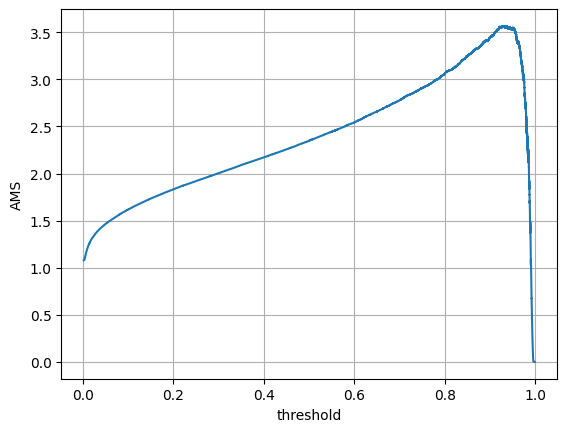

In [73]:
plt.plot(roc_gbc_weighted[2], amsses)
plt.xlabel("threshold")
plt.ylabel("AMS")
plt.grid()